In [1]:
'''

This notebook is basically simalar to the feature selection notebook.
However, tree plotting was added.

'''
import random
import pickle
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, MultinomialNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error, r2_score
from sklearn import svm, tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from math import sqrt
import seaborn as sns

from joblib import dump
from collections import Counter

In [2]:
df = pd.read_csv('../preprocessed_data/p_train.csv')
st = pd.read_csv('../preprocessed_data/PerStatus.csv')

data = df.T.append(st.T).T

/var/folders/p1/jtrqrk8964n_9ppqllxb9m280000gn/T/ipykernel_92534/71531640.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df.T.append(st.T).T


In [3]:
X = df.iloc[:, :df.shape[1]]
Y = st.iloc[:,0]

In [4]:
#Make pipeline of clf
clf_pipeline = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier())
y_pred = cross_val_predict(clf_pipeline, X, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('RMSE:', round(sqrt(mean_squared_error(Y, y_pred)), 2))
print('R_squared:', round(r2_score(Y, y_pred), 2))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

Accuracy score: 0.8834769316286826
RMSE: 0.34
R_squared: -1.23
Recall score: 0.1658291457286432
Fbeta score: 0.14611716621253404


# Filter Features by Variance

In [5]:
var_thresh = 0.75
var = df.var()
idx = []
for i in range(len(var)):
    if var[i] < var_thresh:
        print('{:50} {}'.format(var.index[i], var[i]))
        idx.append(var.index[i])

sex                                                0.20977519706996783
Job classification                                 0.09741209233474585
Work experience1                                   0.028267770616161987
Work experience2                                   0.04946226756277056
Work experience3                                   0.056616660310785785
Work experience4                                   0.053117377071064065
Work experience5                                   0.17650466644487714
Promotion or Not                                   0.06585434221383735
leave this three mon. B                            0.14219320340607236
leave this year B                                  0.2533759219841596
Business Trip B                                    0.3796519601895895
Marital Status                                     0.19452168645487425
Average working years                              0.5833913783045416
highest education                                  0.0971883135686875


In [6]:
print(X.shape)
X_after_variance_filter.drop(columns=idx, inplace=True)
print(X_after_variance_filter.shape)

(14392, 46)
(14392, 32)


In [14]:
y_pred = cross_val_predict(clf_pipeline, X_after_variance_filter, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('RMSE:', round(sqrt(mean_squared_error(Y, y_pred)), 2))
print('R_squared:', round(r2_score(Y, y_pred), 2))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

Accuracy score: 0.9446914952751528
RMSE: 0.24
R_squared: -0.06
Recall score: 0.007537688442211055
Fbeta score: 0.0108153078202995


# Filter Features by Correlation

In [23]:
abs(data.corr()['PerStatus']).mean()

0.05530186176962964

In [24]:
vals = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
for val in vals:
    features = abs(data.corr()['PerStatus'][abs(data.corr()['PerStatus']) > val].drop('PerStatus')).index.tolist()
    
    testc = data.drop(columns='PerStatus')
    testc = X[features]
    
    print(features)
    
    y_pred = cross_val_predict(clf_pipeline, testc, Y, cv=10)
    print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
    print('RMSE:', round(sqrt(mean_squared_error(Y, y_pred)), 2))
    print('R_squared:', round(r2_score(Y, y_pred), 2))
    print('Recall score:', metrics.recall_score(Y, y_pred))
    print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

TypeError: import_optional_dependency() got an unexpected keyword argument 'errors'

In [25]:
X_after_correlation_filter = X[['sex', 'Job classification', 'Work experience5', 'Special project', 'Training hours C', 'Promotion speed', 'leave this year A', 'leave this three mon. B', 'leave this year B', 'Age level', 'Marital Status', 'Job tenure level A', 'Job tenure level B', 'Average working years', 'Family numbers']]

# Sequential Feature Selector

In [74]:
X.shape

(14392, 46)

In [75]:
sfsl = SFS(clf_pipeline, 
           k_features = 15, 
           forward=True, 
           scoring=make_scorer(fbeta_score, beta=1.5), 
           cv=10)

sfsl.fit(X, Y)
sfsl.subsets_

{1: {'feature_idx': (44,),
  'cv_scores': array([0.06989247, 0.        , 0.05193076, 0.        , 0.03576341,
         0.03596127, 0.03457447, 0.08419689, 0.03551913, 0.03551913]),
  'avg_score': 0.0383357526504257,
  'feature_names': ('Affiliated department',)},
 2: {'feature_idx': (17, 44),
  'cv_scores': array([0.13333333, 0.01719577, 0.0513834 , 0.01740295, 0.07036536,
         0.05335157, 0.0515873 , 0.11607143, 0.05241935, 0.08507853]),
  'avg_score': 0.0648188995661336,
  'feature_names': ('Training hours B', 'Affiliated department')},
 3: {'feature_idx': (17, 44, 45),
  'cv_scores': array([0.1702381 , 0.05078125, 0.04881101, 0.04832714, 0.08344031,
         0.06540881, 0.065     , 0.13668224, 0.06598985, 0.08125   ]),
  'avg_score': 0.08159287003769009,
  'feature_names': ('Training hours B',
   'Affiliated department',
   'Work Overtime')},
 4: {'feature_idx': (17, 34, 44, 45),
  'cv_scores': array([0.23423423, 0.03350515, 0.09617756, 0.10950662, 0.10898204,
         0.12395709

In [57]:
X = X[[]]

y_pred = cross_val_predict(clf_pipeline, X, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('Precision:', metrics.precision_score(Y, y_pred))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))
print('F1-score:', f1_score(Y, y_pred))

Accuracy score: 0.8942468037798778
Precision: 0.14411764705882352
Recall score: 0.18467336683417085
Fbeta score: 0.16995731056563498
F1-score: 0.16189427312775329


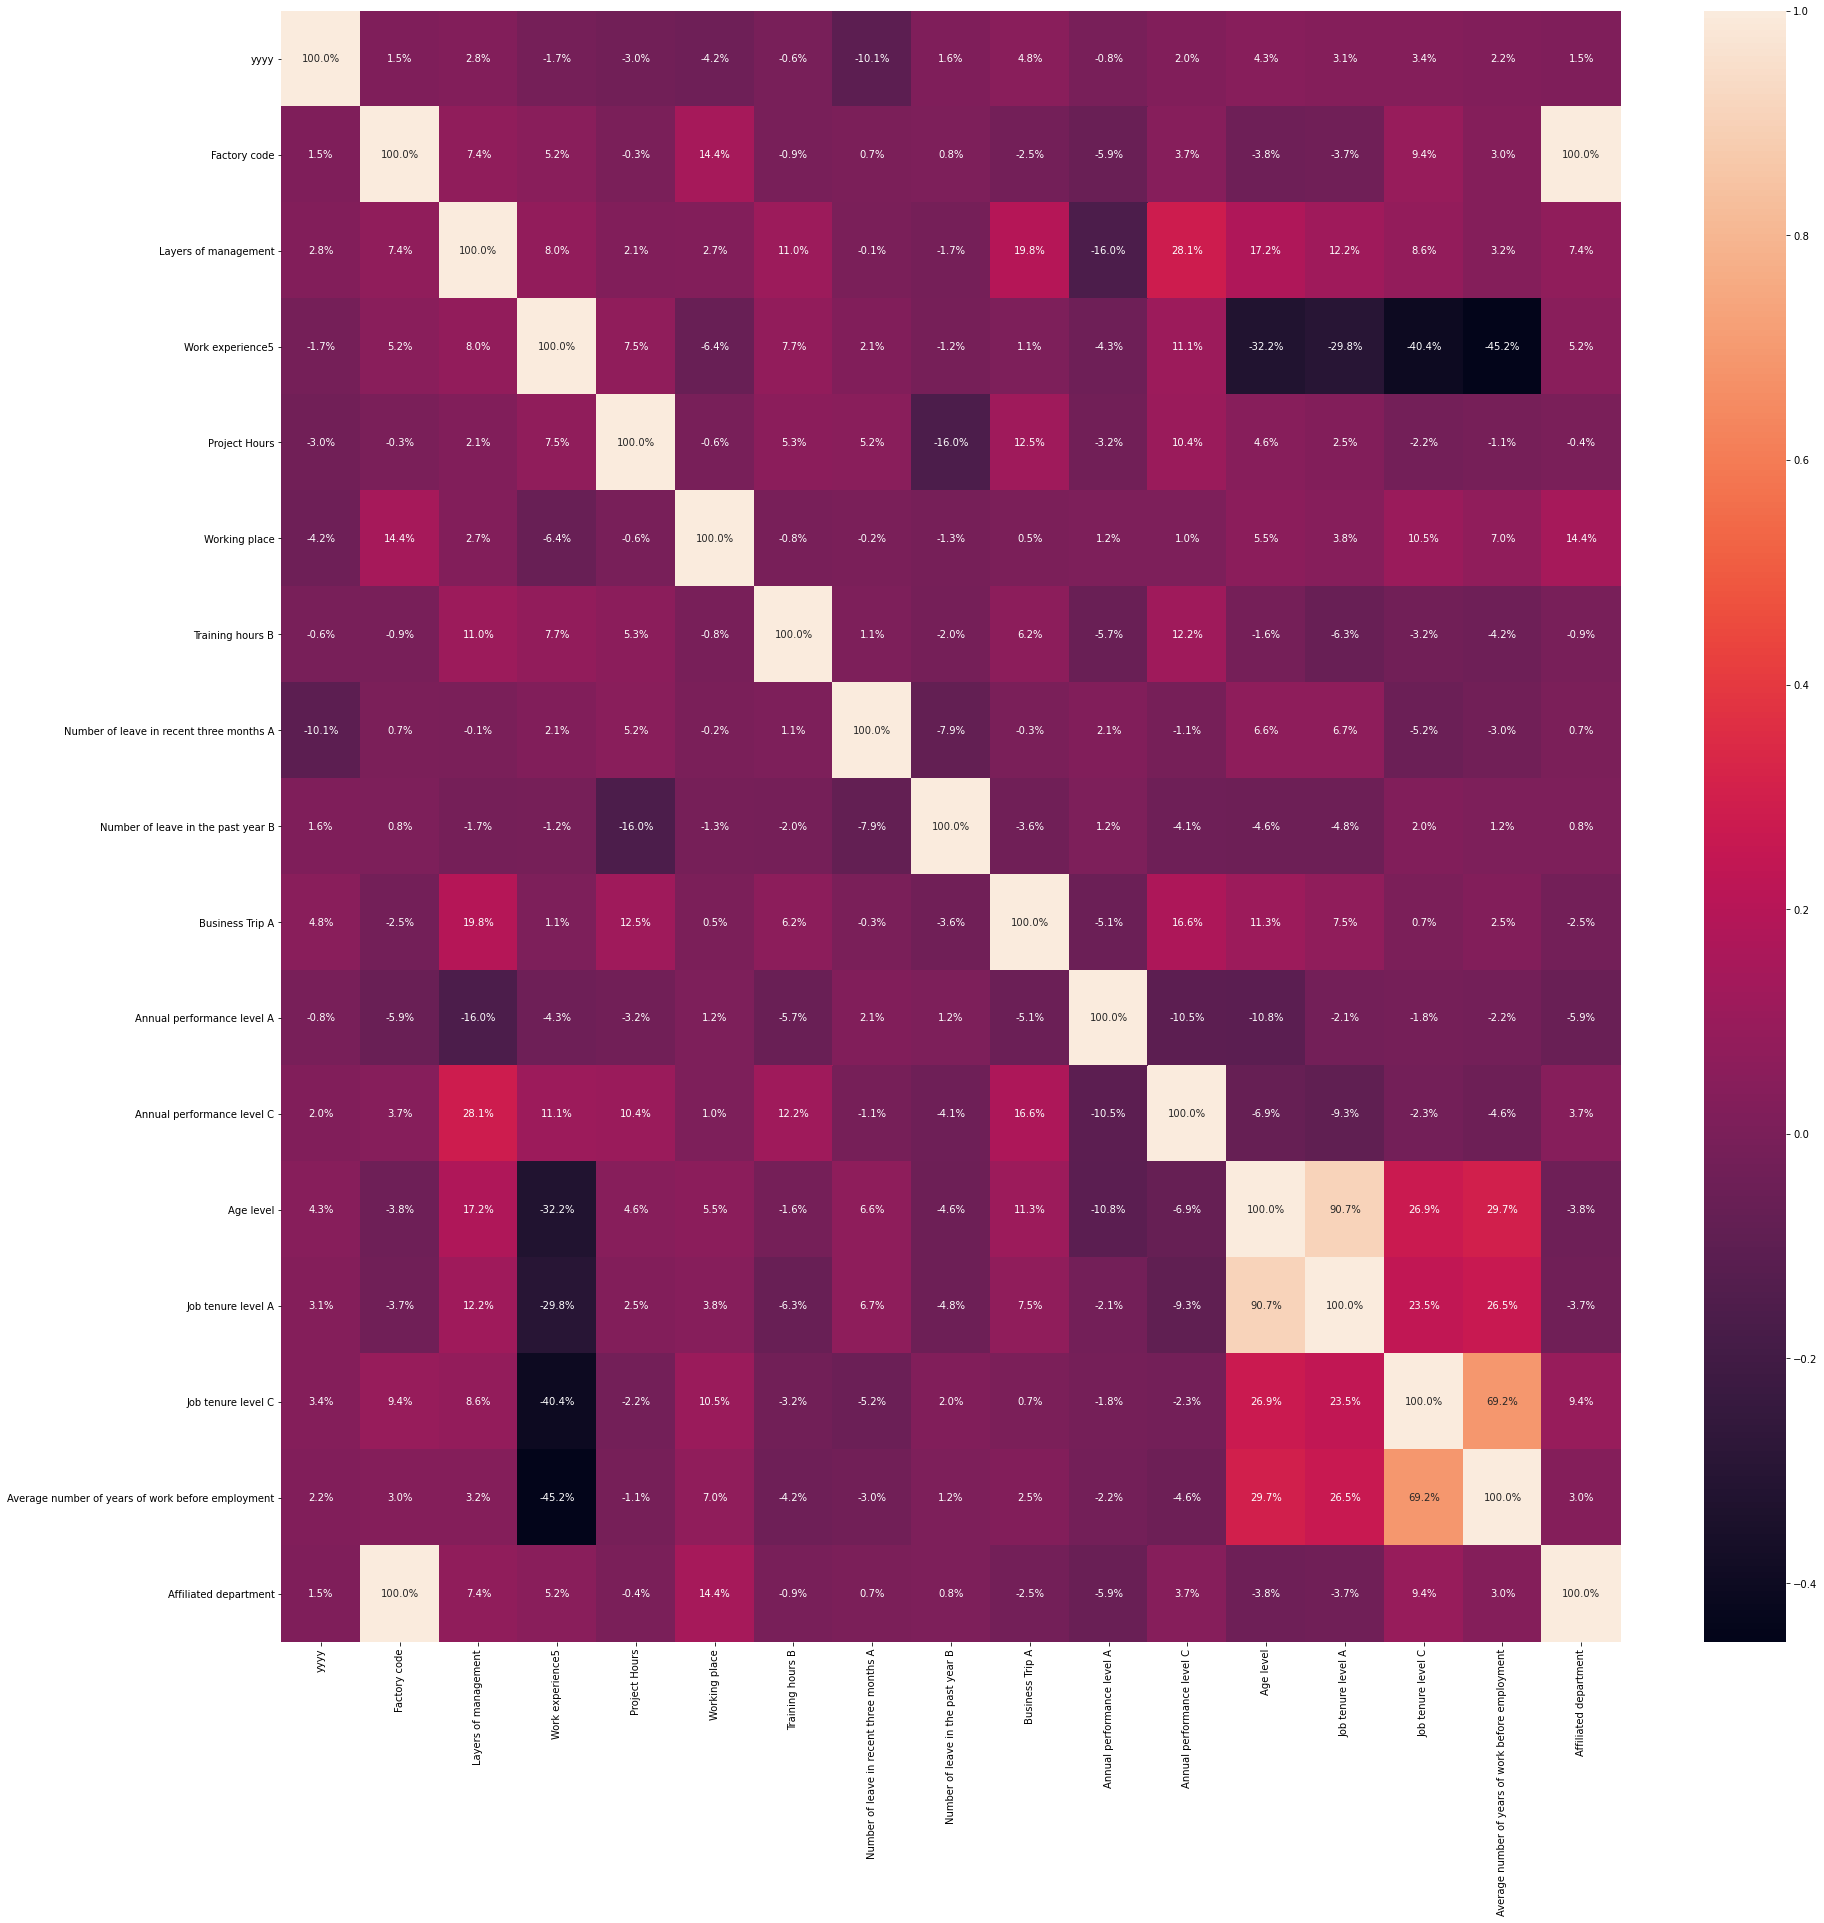

In [159]:
plt.figure(figsize=(30, 30))
sns.heatmap(X[['yyyy', 'Factory code', 'Layers of management', 'Work experience5', 'Project Hours',
              'Working place', 'Training hours B', 'Number of leave in recent three months A', 
              'Number of leave in the past year B', 'Business Trip A', 'Annual performance level A',
              'Annual performance level C', 'Age level', 'Job tenure level A', 'Job tenure level C',
              'Average number of years of work before employment', 'Affiliated department']].corr(), 
             annot=True, fmt='.1%')

In [ ]:
X['AD*FC'] = X['Affiliated department']*X['Factory code']
X['Al*JTA'] = X['Age level']*X['Job tenure level A']

In [59]:
selected = X

y_pred = cross_val_predict(clf_pipeline, X, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

Accuracy score: 0.8926486937187327
Recall score: 0.1871859296482412
Fbeta score: 0.170630725863284


# Training

In [67]:
#Scaling
scaler = StandardScaler()
scaler.fit(selected)
selected = scaler.transform(selected)
selected = selected[:150, :]
Y = Y[:150]
#print(selected.shape)

#Splitting trainset
x_train, x_test, y_train, y_test = train_test_split(selected, Y, test_size=0.2)

#Classifier
model = tree.DecisionTreeClassifier()

#Cross_val_score(fbeta)
scoring = cross_val_score(model, selected, Y, cv=10, 
                         scoring=metrics.make_scorer(fbeta_score, beta=1.5))
print('Cross_val_score(mean):', scoring.mean())
print('Corss_val_score(std):', scoring.std())

#Fitting trainset
model = model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#Showing Score
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('fbeta:', metrics.fbeta_score(y_test, y_pred, beta=1.5))

Cross_val_score(mean): 0.0
Corss_val_score(std): 0.0
Accuracy: 0.9333333333333333
Recall: 0.0
fbeta: 0.0


/Users/mitch_hsu/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/Users/mitch_hsu/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/mitch_hsu/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/mitch_hsu/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/metrics/_class

In [44]:
X.shape

(14392, 5)

In [68]:
X.columns

Index(['yyyy', 'Training hours B', 'leave this three mon. A',
       'leave this three mon. B', 'B-Trip Concentration',
       'Annual performance B', 'Marital Status', 'Job tenure level B',
       'Affiliated department', 'Work Overtime'],
      dtype='object')

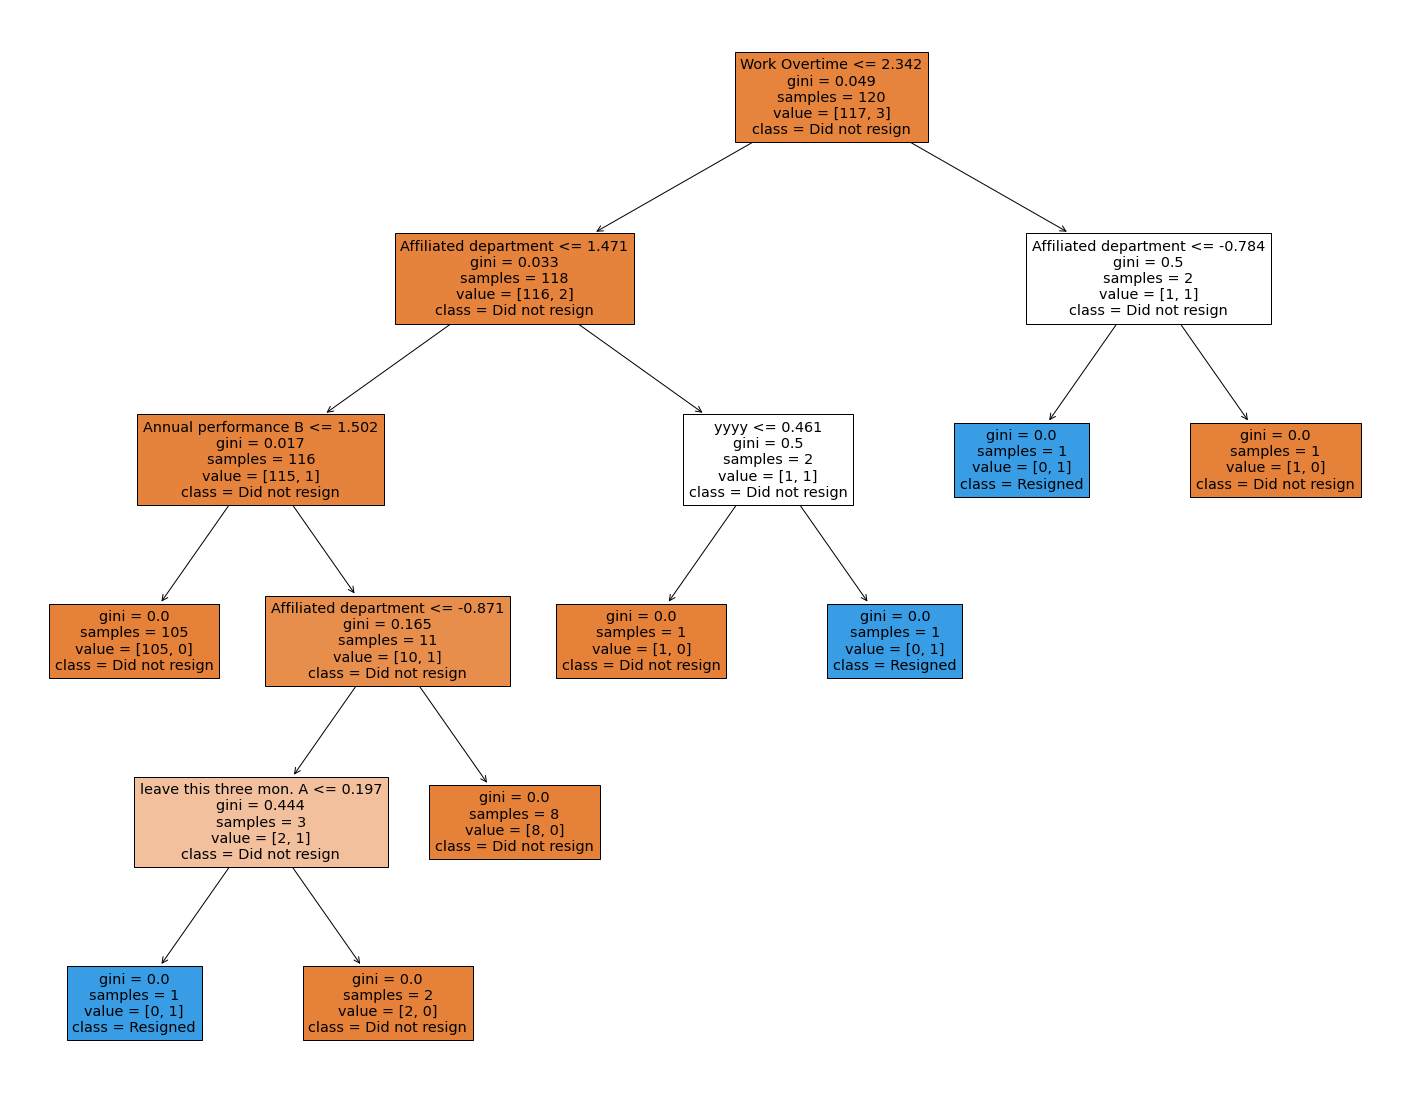

In [69]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=X.columns,  
                   class_names=['Did not resign', 'Resigned'],
                   filled=True)

In [22]:
print('Macro-average: {0}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Micro-average: {0}'.format(metrics.f1_score(y_test, y_pred, average='micro')))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy*100))

print('\n')
print('precision:', metrics.precision_score(y_test, y_pred))
print('recall:', metrics.recall_score(y_test, y_pred))

print('Average = macro')
print('precision:', metrics.precision_score(y_test, y_pred, average='macro'))
print('recall:', metrics.recall_score(y_test, y_pred, average='macro'))
print('F1-score:', metrics.f1_score(y_test, y_pred, average='macro'))

print('\n')
print('Average = micro')
print('precision:', metrics.precision_score(y_test, y_pred, average='micro'))
print('recall:', metrics.recall_score(y_test, y_pred, average='micro'))
print('F1-score:', metrics.f1_score(y_test, y_pred, average='micro'))

print('\n')
print('Average = weighted')
print('precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
print('recall:', metrics.recall_score(y_test, y_pred, average='micro'))
print('F1-score:', metrics.f1_score(y_test, y_pred, average='weighted'))

print('\n')
print('Fbeta score:', metrics.fbeta_score(y_test, y_pred, beta=1.5))
print('F1-score:', metrics.f1_score(y_test, y_pred))

Macro-average: 0.4867177750044571
Micro-average: 0.9482459187217784
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2730
           1       0.00      0.00      0.00       149

    accuracy                           0.95      2879
   macro avg       0.47      0.50      0.49      2879
weighted avg       0.90      0.95      0.92      2879

[[2730    0]
 [ 149    0]]
Accuracy: 94.82%


precision: 0.0
recall: 0.0
Average = macro
precision: 0.4741229593608892
recall: 0.5
F1-score: 0.4867177750044571


Average = micro
precision: 0.9482459187217784
recall: 0.9482459187217784
F1-score: 0.9482459187217784


Average = weighted
precision: 0.8991703223725095
recall: 0.9482459187217784
F1-score: 0.9230562874346425


Fbeta score: 0.0
F1-score: 0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
dump(model, 'last_ext_tunned.joblib')

['last_ext_tunned.joblib']

In [67]:
X

,yyyy,sex,Job classification,Job level,Factory code,Layers of management,Work experience1,Work experience2,Work experience3,Work experience4,...,Job tenure level A,Job tenure level B,Job tenure level C,Average number of years of work before employment,highest education level,Graduated School category,Graduated Department category,Family numbers,Commuting cost,Affiliated department
0,2017,1.0,1.0,4.0,20.0,1.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,1.0,2.0,4.0,6.0,0.0,8.0,20130.0
1,2017,1.0,1.0,2.0,8.0,6.0,0.0,0.0,0.0,0.0,...,5.0,4.0,1.0,1.0,3.0,1.0,8.0,1.0,9.0,8038.0
2,2017,1.0,1.0,7.0,14.0,1.0,0.0,0.0,0.0,0.0,...,3.0,3.0,0.0,0.0,2.0,3.0,5.0,2.0,9.0,14067.0
3,2017,1.0,1.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,...,6.0,4.0,4.0,2.0,2.0,3.0,3.0,1.0,8.0,4010.0
4,2017,1.0,1.0,7.0,13.0,1.0,0.0,0.0,0.0,0.0,...,7.0,7.0,1.0,1.0,3.0,3.0,6.0,1.0,8.0,13151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014,1.0,1.0,4.0,13.0,1.0,0.0,0.0,0.0,0.0,...,7.0,7.0,0.0,1.0,2.0,4.0,3.0,1.0,8.0,13147.0
4596,2014,1.0,1.0,3.0,19.0,4.0,0.0,1.0,0.0,0.0,...,3.0,1.0,4.0,2.0,2.0,4.0,8.0,0.0,8.0,19135.0
4597,2017,0.0,2.0,7.0,13.0,1.0,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,1.0,2.0,3.0,9.0,1.0,8.0,13087.0
4598,2017,1.0,1.0,7.0,13.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,2.0,1.0,3.0,0.0,8.0,13034.0


In [56]:
st.sum()

PerStatus    796
dtype: int64

In [57]:
796/14392

0.055308504724847135

In [58]:
idx

['sex',
 'Job classification',
 'Work experience1',
 'Work experience2',
 'Work experience3',
 'Work experience4',
 'Work experience5',
 'Promotion or Not Promotion',
 'Number of leave in recent three months B',
 'Number of leave in the past year B',
 'Business Trip B',
 'Marital Status',
 'Average number of years of work before employment',
 'highest education level']

In [61]:
from sklearn.datasets import load_iris
iris = load_iris()

In [62]:
iris.data.shape

(150, 4)